In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

In [58]:
#Get all unique tiles
all_filenames=glob.glob("/cloud/KappaZeta/L1C/*/*/*")
all_tiles=[]
for name in all_filenames:
    cur_tile=name.split('/')[-1]
    exist_count=0
    for tile in all_tiles:
        if tile==cur_tile:
            exist_count+=1
            break
    if exist_count==0: #Only append if not appended already
        all_tiles.append(cur_tile)

In [61]:
cur_tile=all_tiles[0]
paths="/cloud/KappaZeta/L1C/*/*/*/*"+cur_tile+".nc"
filenames=glob.glob(paths)
filenames

['/cloud/KappaZeta/L1C/june/S2A_MSIL1C_20200602T092041_N0209_R093_T36VUJ_20200602T104732/tile_11_18/T36VUJ_20200602T092041_tile_11_18.nc',
 '/cloud/KappaZeta/L1C/june/S2A_MSIL1C_20200619T105031_N0209_R051_T31UGU_20200619T125517/tile_11_18/T31UGU_20200619T105031_tile_11_18.nc',
 '/cloud/KappaZeta/L1C/august/S2B_MSIL1C_20200812T112119_N0209_R037_T30UVC_20200812T123206/tile_11_18/T30UVC_20200812T112119_tile_11_18.nc',
 '/cloud/KappaZeta/L1C/may/S2A_MSIL1C_20200511T102031_N0209_R065_T33VVC_20200511T122140/tile_11_18/T33VVC_20200511T102031_tile_11_18.nc',
 '/cloud/KappaZeta/L1C/may/S2B_MSIL1C_20200510T100029_N0209_R122_T33UWR_20200515T004952/tile_11_18/T33UWR_20200510T100029_tile_11_18.nc']

In [62]:
samples=[]
for filename in filenames:
    samples.append(nc.Dataset(filename))

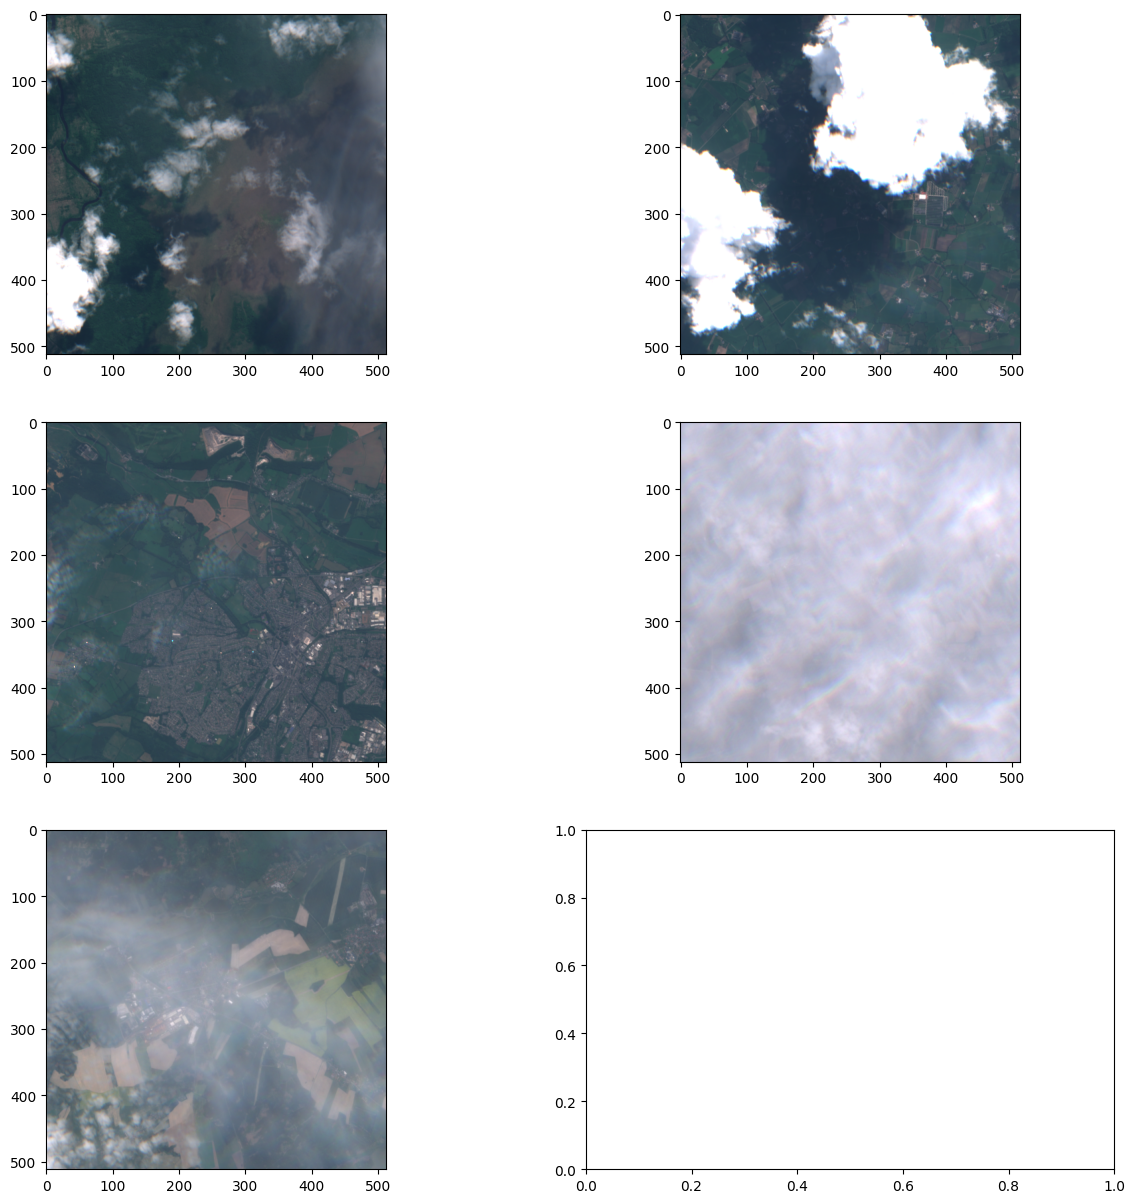

In [63]:
nimages=len(samples)
ncols=2
nrows=int(np.ceil(nimages/2))
plt.rcParams["figure.figsize"] = [15, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    if i < nimages:
        sample=samples[i]
        R=sample.variables['TCI_R'][:].data
        G=sample.variables['TCI_G'][:].data
        B=sample.variables['TCI_B'][:].data
        image=np.zeros((512,512,3))
        image[:,:,0]=R
        image[:,:,1]=G
        image[:,:,2]=B
        image=image/255
        ax.imshow(image)

In [21]:
ds=nc.Dataset(path)

FileNotFoundError: [Errno 2] No such file or directory: "['/cloud/KappaZeta/L1C/april/S2A_MSIL1C_20200402T095031_N0209_R079_T33UYU_20200402T102520/tile_15_13/T33UYU_20200402T095031_tile_15_13.nc', '/cloud/KappaZeta/L1C/august/S2B_MSIL1C_20200819T093039_N0209_R136_T35UMT_20200819T105409/tile_15_13/T35UMT_20200819T093039_tile_15_13.nc', '/cloud/KappaZeta/L1C/may/S2A_MSIL1C_20200509T094041_N0209_R036_T34UEV_20200509T101545/tile_15_13/T34UEV_20200509T094041_tile_15_13.nc']"

In [7]:
ds = nc.Dataset(path)
data=ds.variables['B11'][:].data
data_flat=np.array([j for sub in data for j in sub])

R=ds.variables['TCI_R'][:].data
G=ds.variables['TCI_G'][:].data
B=ds.variables['TCI_B'][:].data
image=np.zeros((512,512,3))
image[:,:,0]=R
image[:,:,1]=G
image[:,:,2]=B
image=image/255

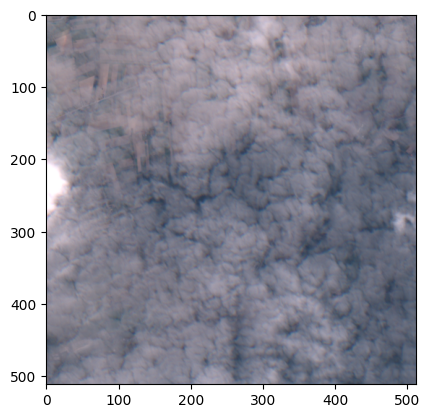

In [8]:
plt.imshow(image)